<a href="https://colab.research.google.com/github/Jackyscy/cv/blob/main/CNN_trial_single.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow.keras.layers import Dense, Input, GlobalMaxPooling1D, \
  GlobalAveragePooling1D, Flatten
from tensorflow.keras.layers import Conv1D, MaxPooling1D, Concatenate, Input, LSTM, GRU, SimpleRNN, Dense, GlobalMaxPool1D,Dense, Input
from tensorflow.keras.models import Model
from tensorflow.keras.losses import SparseCategoricalCrossentropy
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.optimizers import SGD, Adam

from sklearn.metrics import mean_absolute_percentage_error
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import r2_score
from sklearn.preprocessing import StandardScaler

np.random.seed(0)
tf.random.set_seed(0)

In [2]:
df = pd.read_csv('GT data for 3-hour intervel learning1_without_temp_selected_screened.csv'
        )


In [3]:

df["LogSpread1"] = np.log(df['Combust Monitor Actual Spread 1'])
df['DiffLogSpread1'] = df['LogSpread1'].diff()

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2858 entries, 0 to 2857
Data columns (total 16 columns):
 #   Column                           Non-Null Count  Dtype  
---  ------                           --------------  -----  
 0   Date_Time                        2858 non-null   object 
 1   Combust Monitor Actual Spread 1  2858 non-null   float64
 2   GT Exhaust Outlet Temp           2858 non-null   float64
 3   GT Exhaust Outlet temp Expected  2858 non-null   float64
 4   Combust Monitor Actual Spread 3  2858 non-null   float64
 5   GT Exhaust Outlet temp Average   2858 non-null   float64
 6   GT Swirl Angle                   2858 non-null   float64
 7   GT Efficiency Actual (LHV)       2858 non-null   float64
 8   Turbine Speed in RPM             2858 non-null   float64
 9   GT Compres Disch Press           2858 non-null   float64
 10  GT Fuel Gas Mass Flow            2858 non-null   float64
 11  GT IGV Position                  2858 non-null   float64
 12  GT Turbine Inlet Tem

In [5]:
#input_data = df[['GT Exhaust Outlet Temp', 'GT Exhaust Outlet temp Expected',
                 #'Combust Monitor Actual Spread 3', 'GT Exhaust Outlet temp Average',
                 # 'GT Swirl Angle', 'GT Exhaust Outlet Temp',
                 # 'GT Efficiency Actual (LHV)','Turbine Speed in RPM',
                 # 'GT Compres Disch Press','GT Fuel Gas Mass Flow','GT IGV Position',
                 # 'GT Turbine Inlet Temp','GT Gross MW' ]].values

#targets =df['Combust Monitor Actual Spread 1'].values

In [6]:
Ntest = 21
train = df.iloc[:-Ntest]
test = df.iloc[-Ntest:]

In [7]:
# boolean series to index df rows
train_idx = df.index <= train.index[-1]
test_idx = df.index > train.index[-1]

In [8]:
df['DiffLogSpread1'] = df['LogSpread1'].diff()

df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2858 entries, 0 to 2857
Data columns (total 16 columns):
 #   Column                           Non-Null Count  Dtype  
---  ------                           --------------  -----  
 0   Date_Time                        2858 non-null   object 
 1   Combust Monitor Actual Spread 1  2858 non-null   float64
 2   GT Exhaust Outlet Temp           2858 non-null   float64
 3   GT Exhaust Outlet temp Expected  2858 non-null   float64
 4   Combust Monitor Actual Spread 3  2858 non-null   float64
 5   GT Exhaust Outlet temp Average   2858 non-null   float64
 6   GT Swirl Angle                   2858 non-null   float64
 7   GT Efficiency Actual (LHV)       2858 non-null   float64
 8   Turbine Speed in RPM             2858 non-null   float64
 9   GT Compres Disch Press           2858 non-null   float64
 10  GT Fuel Gas Mass Flow            2858 non-null   float64
 11  GT IGV Position                  2858 non-null   float64
 12  GT Turbine Inlet Tem

In [9]:
series = df['DiffLogSpread1']

In [10]:
# Make supervised dataset
series = df['DiffLogSpread1'].dropna().to_numpy()

T = 10
X = []
Y = []
for t in range(len(series) - T):
  x = series[t:t+T]
  X.append(x)
  y = series[t+T]
  Y.append(y)

X = np.array(X).reshape(-1, T, 1)
Y = np.array(Y)
N = len(X)
print("X.shape", X.shape, "Y.shape", Y.shape)

X.shape (2847, 10, 1) Y.shape (2847,)


In [11]:
Xtrain, Ytrain = X[:-Ntest], Y[:-Ntest]
Xtest, Ytest = X[-Ntest:], Y[-Ntest:]

In [12]:
# CNN
i = Input(shape=(T, 1))
x = Conv1D(16, 3, activation='relu')(i)
x = MaxPooling1D(2)(x)
x = Conv1D(32, 3, activation='relu')(x)
x = GlobalMaxPooling1D()(x)
x = Dense(1)(x)
model = Model(i, x)

In [13]:
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 10, 1)]           0         
                                                                 
 conv1d (Conv1D)             (None, 8, 16)             64        
                                                                 
 max_pooling1d (MaxPooling1  (None, 4, 16)             0         
 D)                                                              
                                                                 
 conv1d_1 (Conv1D)           (None, 2, 32)             1568      
                                                                 
 global_max_pooling1d (Glob  (None, 32)                0         
 alMaxPooling1D)                                                 
                                                                 
 dense (Dense)               (None, 1)                 33    

In [14]:
model.compile(
  loss='mse',
  optimizer='adam',
)

In [15]:
r = model.fit(
  Xtrain,
  Ytrain,
  epochs=500,
  validation_data=(Xtest, Ytest)
)

Epoch 1/500
89/89 [==============================] - 13s 6ms/step - loss: 0.0370 - val_loss: 0.0252
Epoch 2/500
89/89 [==============================] - 0s 3ms/step - loss: 0.0337 - val_loss: 0.0216
Epoch 3/500
89/89 [==============================] - 0s 3ms/step - loss: 0.0311 - val_loss: 0.0210
Epoch 4/500
89/89 [==============================] - 0s 3ms/step - loss: 0.0297 - val_loss: 0.0225
Epoch 5/500
89/89 [==============================] - 0s 3ms/step - loss: 0.0290 - val_loss: 0.0222
Epoch 6/500
89/89 [==============================] - 0s 3ms/step - loss: 0.0283 - val_loss: 0.0242
Epoch 7/500
89/89 [==============================] - 0s 3ms/step - loss: 0.0278 - val_loss: 0.0224
Epoch 8/500
89/89 [==============================] - 0s 3ms/step - loss: 0.0274 - val_loss: 0.0252
Epoch 9/500
89/89 [==============================] - 0s 3ms/step - loss: 0.0272 - val_loss: 0.0224
Epoch 10/500
89/89 [==============================] - 0s 3ms/step - loss: 0.0269 - val_loss: 0.0228
Epoch 11

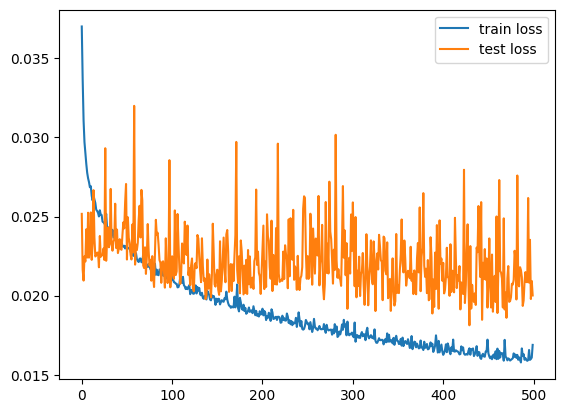

In [16]:
plt.plot(r.history['loss'], label='train loss')
plt.plot(r.history['val_loss'], label='test loss')
plt.legend();

In [17]:
train_idx[:T+1] = False # first T+1 values are not predictable

In [18]:
Ptrain = model.predict(Xtrain).flatten()
Ptest = model.predict(Xtest).flatten()

1/1 [==============================] - 0s 18ms/step


In [19]:
# Store diff predictions
df.loc[train_idx, 'Diff CNN Train Prediction'] = Ptrain
df.loc[test_idx, 'Diff CNN Test Prediction'] = Ptest

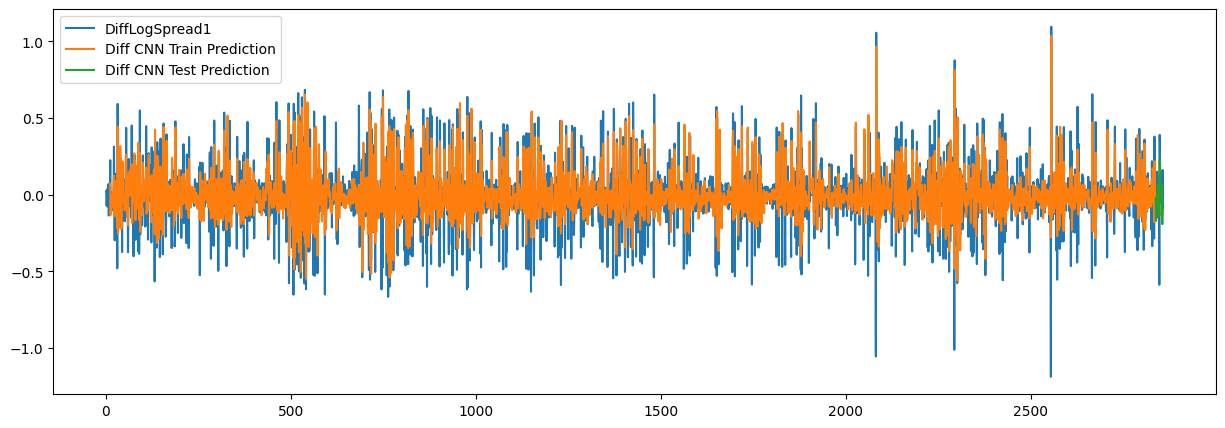

In [20]:
cols = ['DiffLogSpread1',
        'Diff CNN Train Prediction',
        'Diff CNN Test Prediction']
df[cols].plot(figsize=(15, 5));


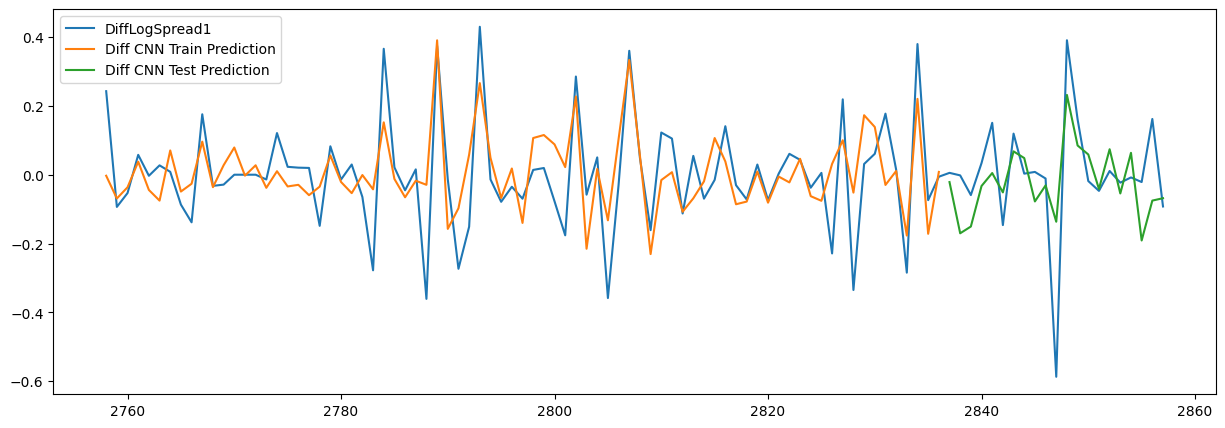

In [21]:
# plot 1-step forecast
df.iloc[-100:][['DiffLogSpread1', 'Diff CNN Train Prediction', 'Diff CNN Test Prediction']].plot(figsize=(15, 5));

In [22]:
# Needed to compute un-differenced predictions
df['ShiftLogSpread1'] = df['LogSpread1'].shift(1)
prev = df['ShiftLogSpread1']

In [23]:
# Last-known train value
last_train = train.iloc[-1]['LogSpread1']

In [24]:
# 1-step forecast
df.loc[train_idx, '1step_train'] = prev[train_idx] + Ptrain
df.loc[test_idx, '1step_test'] = prev[test_idx] + Ptest

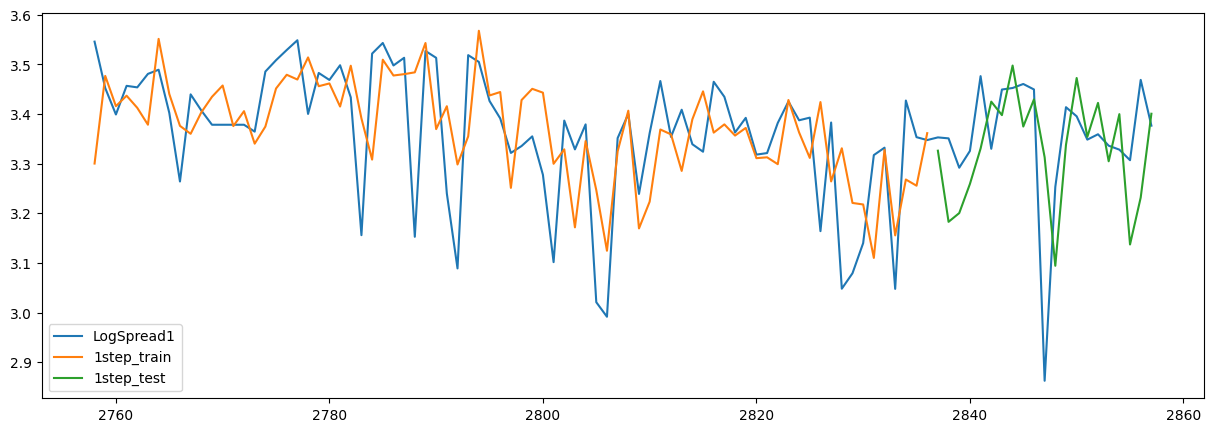

In [25]:
# plot 1-step forecast
df.iloc[-100:][['LogSpread1', '1step_train', '1step_test']].plot(figsize=(15, 5));

In [26]:
# multi-step forecast
multistep_predictions = []

# first test input
last_x = Xtest[0]

while len(multistep_predictions) < Ntest:
  p = model.predict(last_x.reshape(1, -1, 1))[0]

  # update the predictions list
  multistep_predictions.append(p)

  # make the new input
  last_x = np.roll(last_x, -1)
  last_x[-1] = p

1/1 [==============================] - 0s 18ms/step


In [27]:
# save multi-step forecast to dataframe
df.loc[test_idx, 'multistep'] = last_train + np.cumsum(multistep_predictions)

In [28]:
# save multi-step forecast to dataframe
df.loc[test_idx, 'multistep'] = last_train + np.cumsum(multistep_predictions)

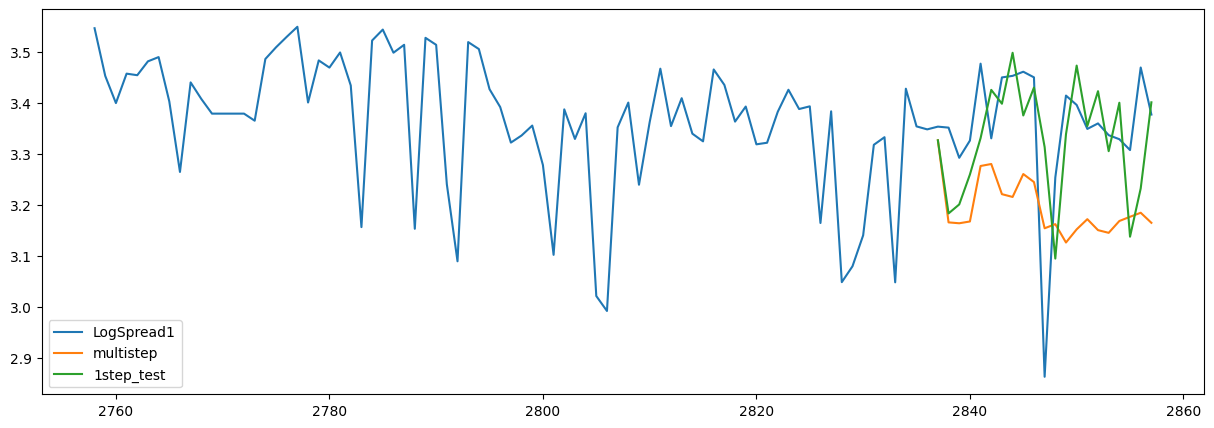

In [29]:
# plot 1-step and multi-step forecast
df.iloc[-100:][['LogSpread1', 'multistep', '1step_test']].plot(figsize=(15, 5));

In [30]:
# make multi-output supervised dataset
Tx = T
Ty = Ntest
X = []
Y = []
for t in range(len(series) - Tx - Ty + 1):
  x = series[t:t+Tx]
  X.append(x)
  y = series[t+Tx:t+Tx+Ty]
  Y.append(y)

X = np.array(X).reshape(-1, Tx, 1)
Y = np.array(Y).reshape(-1, Ty)
N = len(X)
print("X.shape", X.shape, "Y.shape", Y.shape)

X.shape (2827, 10, 1) Y.shape (2827, 21)


In [31]:
Xtrain_m, Ytrain_m = X[:-1], Y[:-1]
Xtest_m, Ytest_m = X[-1:], Y[-1:]

In [32]:
# CNN
i = Input(shape=(Tx, 1))
x = Conv1D(16, 3, activation='relu')(i)
x = MaxPooling1D(2)(x)
x = Conv1D(32, 3, activation='relu')(x)
x = GlobalMaxPooling1D()(x)
x = Dense(Ty)(x)
model = Model(i, x)

In [33]:
model.compile(
  loss='mse',
  optimizer='adam',
)

In [34]:
r = model.fit(
  Xtrain_m,
  Ytrain_m,
  epochs=500,
  validation_data=(Xtest_m, Ytest_m)
)

Epoch 1/500
89/89 [==============================] - 2s 4ms/step - loss: 0.0400 - val_loss: 0.0293
Epoch 2/500
89/89 [==============================] - 0s 3ms/step - loss: 0.0396 - val_loss: 0.0303
Epoch 3/500
89/89 [==============================] - 0s 3ms/step - loss: 0.0395 - val_loss: 0.0299
Epoch 4/500
89/89 [==============================] - 0s 3ms/step - loss: 0.0394 - val_loss: 0.0301
Epoch 5/500
89/89 [==============================] - 0s 3ms/step - loss: 0.0393 - val_loss: 0.0298
Epoch 6/500
89/89 [==============================] - 0s 3ms/step - loss: 0.0392 - val_loss: 0.0301
Epoch 7/500
89/89 [==============================] - 0s 3ms/step - loss: 0.0391 - val_loss: 0.0304
Epoch 8/500
89/89 [==============================] - 0s 3ms/step - loss: 0.0391 - val_loss: 0.0309
Epoch 9/500
89/89 [==============================] - 0s 3ms/step - loss: 0.0390 - val_loss: 0.0297
Epoch 10/500
89/89 [==============================] - 0s 3ms/step - loss: 0.0389 - val_loss: 0.0308
Epoch 11/

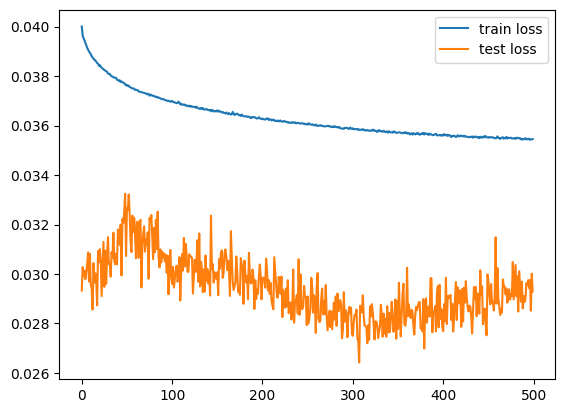

In [35]:
plt.plot(r.history['loss'], label='train loss')
plt.plot(r.history['val_loss'], label='test loss')
plt.legend();

In [36]:
Ptrain = model.predict(Xtrain_m)
Ptest = model.predict(Xtest_m)

1/1 [==============================] - 0s 18ms/step


In [37]:
Ptrain.shape, Ptest.shape

((2826, 21), (1, 21))

In [38]:
Ptrain = Ptrain[:,0]
Ptest = Ptest[0]

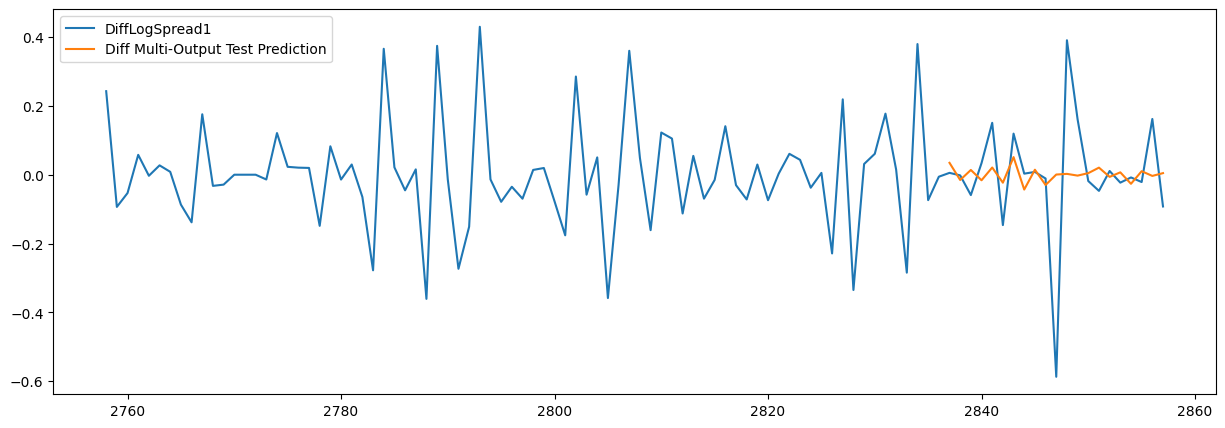

In [39]:
df.loc[test_idx, 'Diff Multi-Output Test Prediction'] = Ptest
cols = ['DiffLogSpread1', 'Diff Multi-Output Test Prediction']
df[-100:][cols].plot(figsize=(15, 5));

#df.iloc[-100:][['LogSpread1', 'multistep', '1step_test']].plot(figsize=(15, 5));

In [40]:
# save multi-output forecast to dataframe
df.loc[test_idx, 'multioutput'] = last_train + \
  np.cumsum(Ptest)

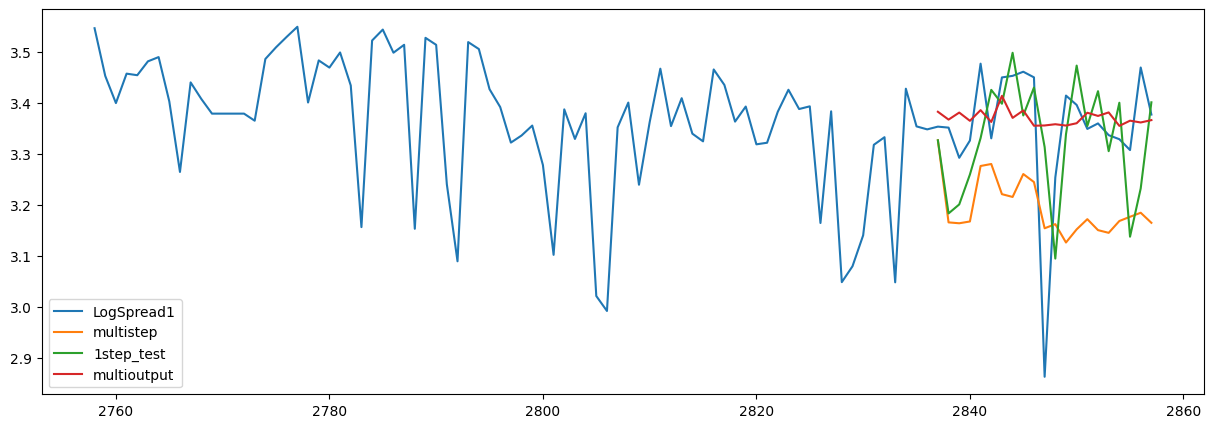

In [41]:
# plot all forecasts
cols = ['LogSpread1', 'multistep', '1step_test', 'multioutput']
df.iloc[-100:][cols].plot(figsize=(15, 5));

In [42]:
# MAPE
test_log_pass = df.iloc[-Ntest:]['LogSpread1']
mape1 = mean_absolute_percentage_error(
    test_log_pass, df.loc[test_idx, 'multistep'])
print("multi-step MAPE:", mape1)
mape2 = mean_absolute_percentage_error(
    test_log_pass, df.loc[test_idx, 'multioutput'])
print("multi-output MAPE:", mape2)

multi-step MAPE: 0.05556674514312946
multi-output MAPE: 0.023356508380193357
